In [1]:
import numpy as np
import pandas as pd
from scipy.spatial import distance 
from sklearn.utils import validation
from sklearn.metrics import pairwise
from scipy.sparse import issparse
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster
from matplotlib import pyplot as plt
from scipy.spatial.distance import squareform 
from scipy import cluster
from scipy.stats import mode
from sklearn.metrics import accuracy_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns
from scipy.cluster.hierarchy import cophenet
np.set_printoptions(precision=5, suppress=True)
import warnings
from sklearn.cluster import AgglomerativeClustering
warnings.filterwarnings('ignore')

In [2]:
def check_pairwise_arrays(X, Y, precomputed=False, dtype=None):
    X, Y, dtype_float = pairwise._return_float_dtype(X, Y)

    warn_on_dtype = dtype is not None
    estimator = 'check_pairwise_arrays'
    if dtype is None:
        dtype = dtype_float

    if Y is X or Y is None:
        X = Y = validation.check_array(X, accept_sparse='csr', dtype=dtype,
                            warn_on_dtype=warn_on_dtype, estimator=estimator)
    else:
        X = validation.check_array(X, accept_sparse='csr', dtype=dtype,
                        warn_on_dtype=warn_on_dtype, estimator=estimator)
        Y = validation.check_array(Y, accept_sparse='csr', dtype=dtype,
                        warn_on_dtype=warn_on_dtype, estimator=estimator)

    if precomputed:
        if X.shape[1] != Y.shape[0]:
            raise ValueError("Precomputed metric requires shape "
                             "(n_queries, n_indexed). Got (%d, %d) "
                             "for %d indexed." %
                             (X.shape[0], X.shape[1], Y.shape[0]))
    elif X.shape[1] != Y.shape[1]:
        raise ValueError("Incompatible dimension for X and Y matrices: "
                         "X.shape[1] == %d while Y.shape[1] == %d" % (
                             X.shape[1], Y.shape[1]))

    return X, Y


In [3]:

# Vectorized Version
def gower_distances(X, Y=None, feature_weight=None, categorical_features=None):
    """Computes the gower distances between X and Y

    Gower is a similarity measure for categorical, boolean and numerical mixed
    data.

    
    Parameters
    ----------
    X : array-like, or pandas.DataFrame, shape (n_samples, n_features)

    Y : array-like, or pandas.DataFrame, shape (n_samples, n_features)

    feature_weight :  array-like, shape (n_features)
        According the Gower formula, feature_weight is an attribute weight.

    categorical_features: array-like, shape (n_features)
        Indicates with True/False whether a column is a categorical attribute.
        This is useful when categorical atributes are represented as integer
        values. Categorical ordinal attributes are treated as numeric, and must
        be marked as false.
        
        Alternatively, the categorical_features array can be represented only
        with the numerical indexes of the categorical attribtes.

    Returns
    -------
    similarities : ndarray, shape (n_samples, n_samples)

    Notes
    ------
    The non-numeric features, and numeric feature ranges are determined from X and not Y.
    No support for sparse matrices.

    """
    
    if issparse(X) or issparse(Y):
        raise TypeError("Sparse matrices are not supported for gower distance")
        
    y_none = Y is None
    
    
    # It is necessary to convert to ndarray in advance to define the dtype
    if not isinstance(X, np.ndarray):
        X = np.asarray(X)

    array_type = np.object
    # this is necessary as strangelly the validator is rejecting numeric
    # arrays with NaN
    if  np.issubdtype(X.dtype, np.number) and (np.isfinite(X.sum()) or np.isfinite(X).all()):
        array_type = type(np.zeros(1,X.dtype).flat[0])
    
    X, Y = check_pairwise_arrays(X, Y, precomputed=False, dtype=array_type)
    
    n_rows, n_cols = X.shape
    
    if categorical_features is None:
        categorical_features = np.zeros(n_cols, dtype=bool)
        for col in range(n_cols):
            # In numerical columns, None is converted to NaN,
            # and the type of NaN is recognized as a number subtype
            if not np.issubdtype(type(X[0, col]), np.number):
                categorical_features[col]=True
    else:          
        categorical_features = np.array(categorical_features)
    
    
    #if categorical_features.dtype == np.int32:
    if np.issubdtype(categorical_features.dtype, np.int):
        new_categorical_features = np.zeros(n_cols, dtype=bool)
        new_categorical_features[categorical_features] = True
        categorical_features = new_categorical_features
    
    print(categorical_features)
  
    # Categorical columns
    X_cat =  X[:,categorical_features]
    
    # Numerical columns
    X_num = X[:,np.logical_not(categorical_features)]
    ranges_of_numeric = None
    max_of_numeric = None
    
        
    # Calculates the normalized ranges and max values of numeric values
    _ ,num_cols=X_num.shape
    ranges_of_numeric = np.zeros(num_cols)
    max_of_numeric = np.zeros(num_cols)
    for col in range(num_cols):
        col_array = X_num[:, col].astype(np.float32) 
        max = np.nanmax(col_array)
        min = np.nanmin(col_array)
     
        if np.isnan(max):
            max = 0.0
        if np.isnan(min):
            min = 0.0
        max_of_numeric[col] = max
        ranges_of_numeric[col] = (1 - min / max) if (max != 0) else 0.0


    # This is to normalize the numeric values between 0 and 1.
    X_num = np.divide(X_num ,max_of_numeric,out=np.zeros_like(X_num), where=max_of_numeric!=0)

    
    if feature_weight is None:
        feature_weight = np.ones(n_cols)
        
    feature_weight_cat=feature_weight[categorical_features]
    feature_weight_num=feature_weight[np.logical_not(categorical_features)]
    
    
    y_n_rows, _ = Y.shape
    
    dm = np.zeros((n_rows, y_n_rows), dtype=np.float32)
        
    feature_weight_sum = feature_weight.sum()

    Y_cat=None
    Y_num=None
    
    if not y_none:
        Y_cat = Y[:,categorical_features]
        Y_num = Y[:,np.logical_not(categorical_features)]
        # This is to normalize the numeric values between 0 and 1.
        Y_num = np.divide(Y_num ,max_of_numeric,out=np.zeros_like(Y_num), where=max_of_numeric!=0)
    else:
        Y_cat=X_cat
        Y_num = X_num
        
    for i in range(n_rows):
        j_start= i
        
        # for non square results
        if n_rows != y_n_rows:
            j_start = 0

      
        Y_cat[j_start:n_rows,:]
        Y_num[j_start:n_rows,:]
        result= _gower_distance_row(X_cat[i,:], X_num[i,:],Y_cat[j_start:n_rows,:],
                                    Y_num[j_start:n_rows,:],feature_weight_cat,feature_weight_num,
                                    feature_weight_sum,categorical_features,ranges_of_numeric,
                                    max_of_numeric) 
        dm[i,j_start:]=result
        dm[i:,j_start]=result
        

    return dm


def _gower_distance_row(xi_cat,xi_num,xj_cat,xj_num,feature_weight_cat,feature_weight_num,
                        feature_weight_sum,categorical_features,ranges_of_numeric,max_of_numeric ):
    # categorical columns
    sij_cat = np.where(xi_cat == xj_cat,np.zeros_like(xi_cat),np.ones_like(xi_cat))
    sum_cat = np.multiply(feature_weight_cat,sij_cat).sum(axis=1) 

    # numerical columns
    abs_delta=np.absolute( xi_num-xj_num)
    sij_num=np.divide(abs_delta, ranges_of_numeric, out=np.zeros_like(abs_delta), where=ranges_of_numeric!=0)

    sum_num = np.multiply(feature_weight_num,sij_num).sum(axis=1)
    sums= np.add(sum_cat,sum_num)
    sum_sij = np.divide(sums,feature_weight_sum)
    return sum_sij


In [4]:
def show_output(label,target,method, k):
    """
    Performs appropiate permutation
    Calculates overlap and confusion matrix
    
    Parameters:
    ----------
        label: cluster group predicted by cluster algorithm
        target: benchmark cluster group
        method: method used for clustering
        
    """
    # label = y_pred
    # target = y_true


    labels = np.zeros_like(label)
    for i in range(10):
        mask = (label == i)
        labels[mask] = mode(target[mask])[0]
    
     
    print("Method: %s"%(method))
    print("Percentage overlap with default clustering:%0.3f"%(accuracy_score(target,labels)))
    print("Homogeneity: %0.3f" % metrics.homogeneity_score(target, labels))
    print("Completeness: %0.3f" % metrics.completeness_score(target, labels))
    print("V-measure: %0.3f" % metrics.v_measure_score(target, labels))


In [5]:
nb_clust = 10

#read the species x traits matrix
df= pd.read_table("../data/T.dta",delimiter='\t')
df.rename( columns={'Unnamed: 0':'Species_code'}, inplace=True )


true_df = df
#Creating two datasets one with categorical values and the other one without
df_with_categorical_values = df.drop(['Species_code'],axis=1)
df_without_categorical_values = df.drop(['Species_code','AM','ECM','A.G','Disp'],axis=1)
#df_without_categorical_values.head()
df_with_categorical_values.head()


cols_to_keep = ['AM','ECM','A.G','Disp']
df_cat = df[cols_to_keep]
df.head()

Species_code     SeedM        Wd         LMA     Nmass   Shade-T  Drought-T  \
0         ABAL  1.834421  0.350000  185.611741  1.720000  4.600000   1.810000   
1         ABBA  0.934498  0.330000  143.000000  1.450000  5.010000   1.000000   
2         ABCO  1.582063  0.370000  164.604357  1.688749  4.330000   1.910000   
3         ABKO  1.041393  0.354231  164.604357  1.688749  4.643333   1.573333   
4         ABSI  1.041393  0.354231  164.604357  1.688749  4.090000   1.410000   

   Waterlog-T  AM ECM A.G Disp  
0     1.020000  N   Y   G    W  
1     2.000000  N   Y   G    W  
2     1.020000  N   Y   G    W  
3     1.346667  N   Y   G    W  
4     1.570000  N   Y   G    W

In [6]:
#Read benchmark data
df2 = pd.read_table("../data/FG.out",delimiter='\t')
df2.rename( columns={'Unnamed: 0':'Species_index'}, inplace=True )
#La colonne 10 représente le ground truth
#print(df2.groupby("10").count()['Species_index'])
true_df.head()
true_df["class"] = pd.Series(df2['10'])
target = true_df["class"] 
print(true_df.groupby("class").count()['Species_code'])

class
1     20
2     42
3     37
4      9
5     38
6     37
7     39
8     19
9      8
10    22
Name: Species_code, dtype: int64


In [7]:
#assign weights to traits like allain in his R script
#since the traits can be ordinal, nominal or numeric; calculate gower distance matrix  
weights = np.array([1,0.7,1,1,1,1,1, 0.1, 0.1, 1, 0.1])
D = gower_distances(df_with_categorical_values,feature_weight=weights)
print(D)

#D = gower_distances(df.iloc[:,1:])
#print(D)

[False False False False False False False  True  True  True  True]
[[0.      0.10983 0.02545 ... 0.27575 0.39558 0.35211]
 [0.10983 0.      0.11298 ... 0.37237 0.3819  0.35677]
 [0.02545 0.11298 0.      ... 0.26477 0.37272 0.32925]
 ...
 [0.27575 0.37237 0.26477 ... 0.      0.14291 0.0957 ]
 [0.39558 0.3819  0.37272 ... 0.14291 0.      0.11731]
 [0.35211 0.35677 0.32925 ... 0.0957  0.11731 0.     ]]


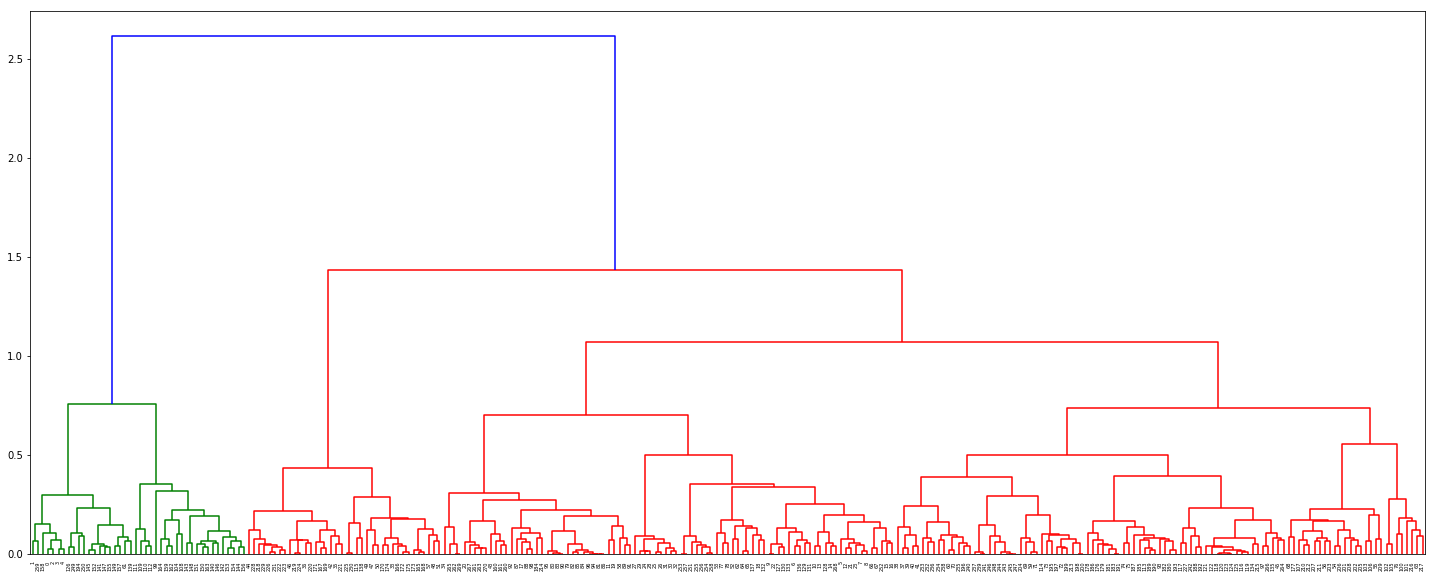

In [8]:
cond_D = squareform(D)
Z = linkage(cond_D, 'ward')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z)

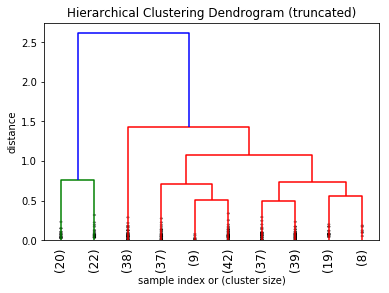

In [9]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=10,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()



In [10]:
"""
Calculates the cophenetic distances between each observation in the hierarchical clustering defined by the linkage Z.
Suppose p and q are original observations in disjoint clusters s and t, respectively and s and t are joined by a direct 
parent cluster u. The cophenetic distance between observations i and j is simply the distance between clusters s and t."""
c,coph_dists = cophenet(Z,cond_D)    
print('Check correlation between cluster distances and actual distances:%f'%(c))

Check correlation between cluster distances and actual distances:0.847474


In [11]:
clusters = fcluster(Z, nb_clust, criterion='maxclust')

In [12]:
show_output(clusters,target,'Hierarchical clustering', nb_clust)

Method: Hierarchical clustering
Percentage overlap with default clustering:0.970
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000


In [18]:
df["class"] = pd.Series(fcluster(Z, 2, criterion='maxclust'))
print(df)

    Species_code     SeedM        Wd         LMA     Nmass   Shade-T  \
0           ABAL  1.834421  0.350000  185.611741  1.720000  4.600000   
1           ABBA  0.934498  0.330000  143.000000  1.450000  5.010000   
2           ABCO  1.582063  0.370000  164.604357  1.688749  4.330000   
3           ABKO  1.041393  0.354231  164.604357  1.688749  4.643333   
4           ABSI  1.041393  0.354231  164.604357  1.688749  4.090000   
5           ACCA  2.109916  0.525210   95.238095  1.940000  3.180000   
6           ACFR  2.055378  0.465000   71.093707  1.913838  3.520000   
7           ACGA  1.849481  0.484889   61.100000  1.900000  3.000000   
8           ACGI  1.450557  0.484889   61.100000  1.900000  3.000000   
9           ACGR  2.269046  0.484889   61.100000  1.900000  3.000000   
10          ACMI  1.591065  0.484889   61.100000  1.900000  3.592308   
11          ACNE  1.568202  0.416000   37.037037  2.500000  3.470000   
12          ACNI  1.749736  0.520000   70.630000  1.830000  3.00

In [13]:
# Perform agglomerative clustering.
# The affinity is precomputed (since the distance are precalculated).
# Use an 'average' linkage. Use any other apart from  'ward'.
agg = AgglomerativeClustering(n_clusters=10, affinity='precomputed',
                              linkage='average')

# Use the distance matrix directly.
u = agg.fit_predict(D)


In [14]:
show_output(u,target,'AgglomerativeClustering', nb_clust)

Method: AgglomerativeClustering
Percentage overlap with default clustering:0.554
Homogeneity: 0.586
Completeness: 0.878
V-measure: 0.702


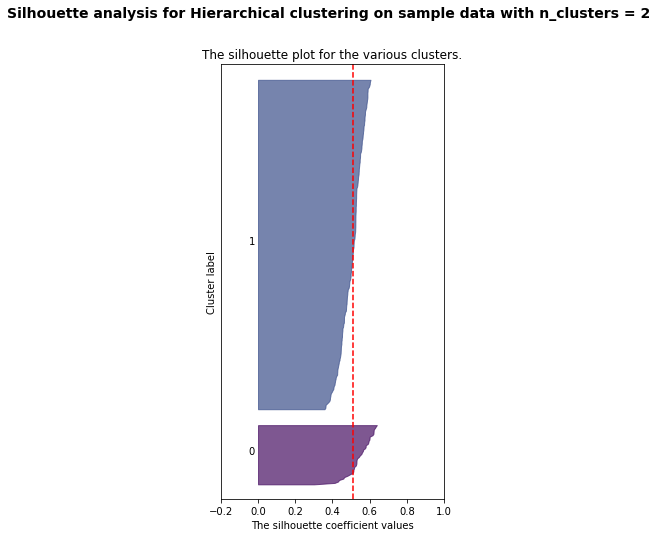

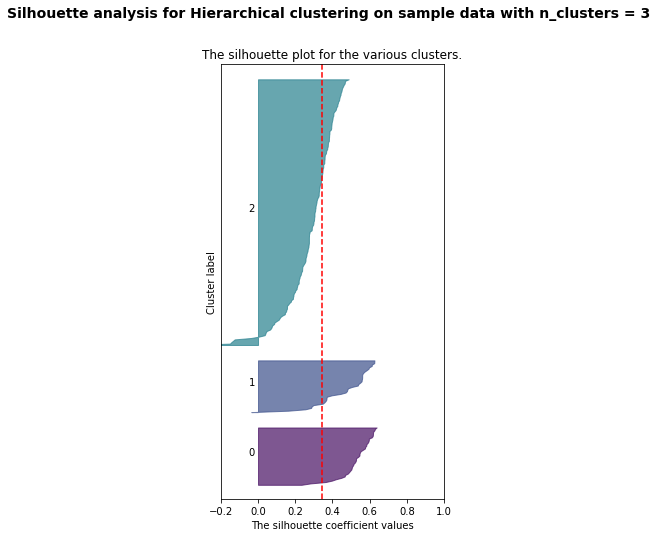

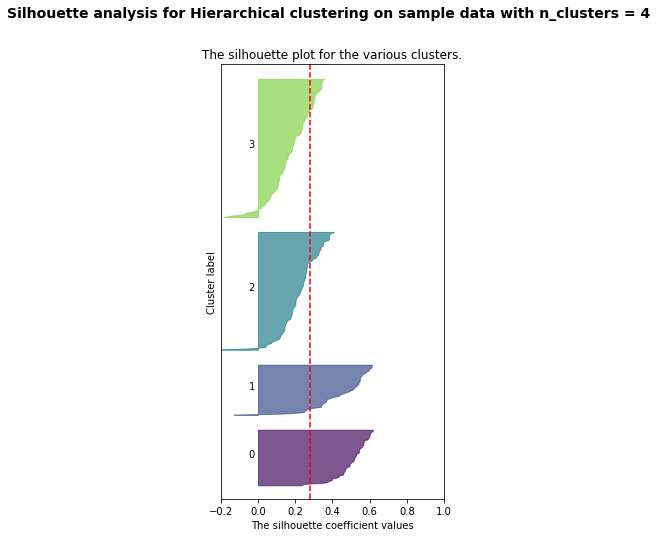

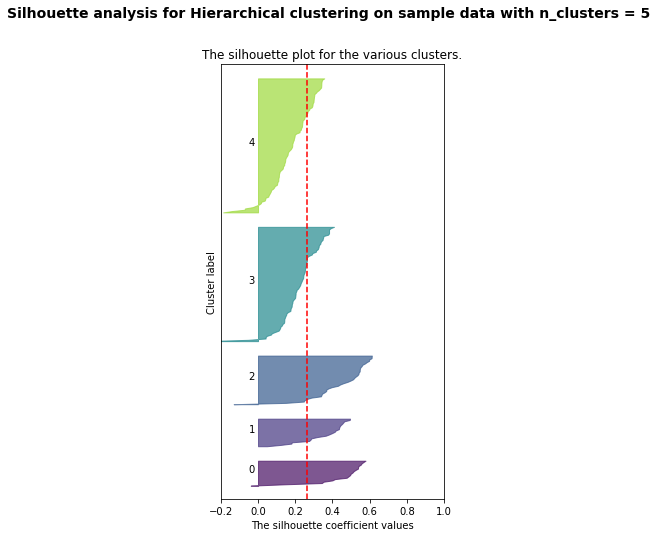

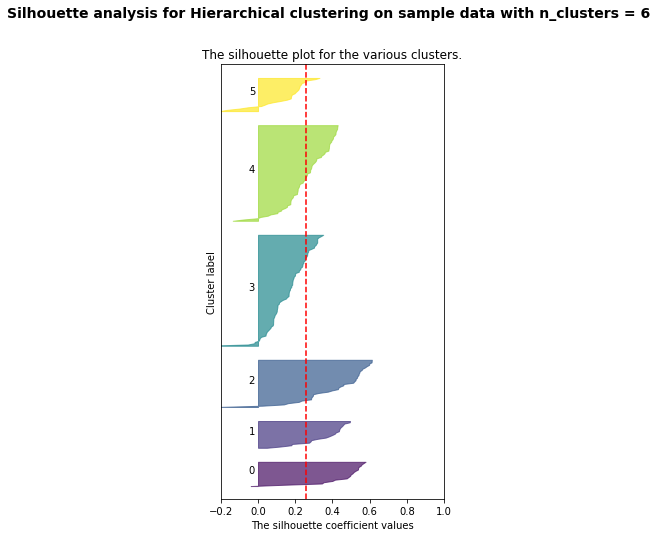

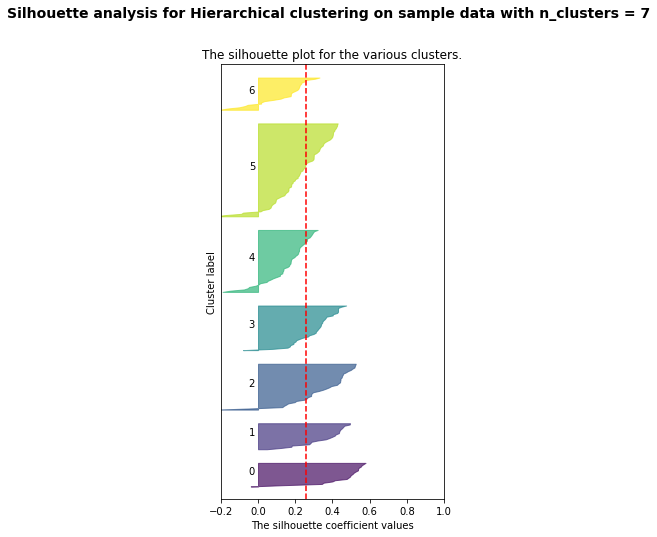

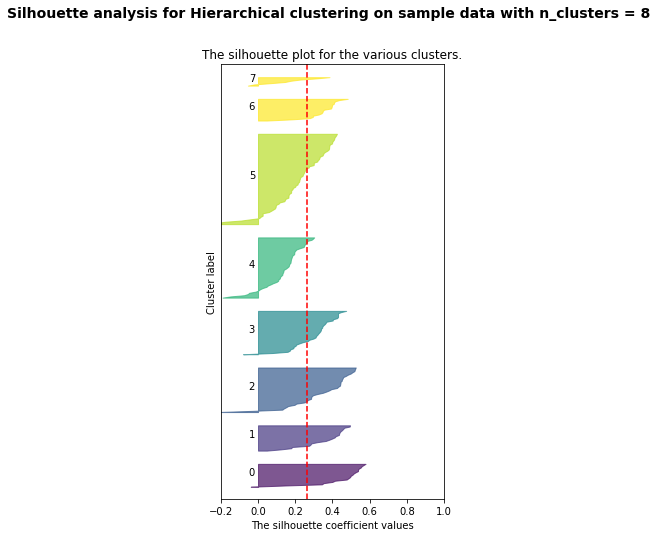

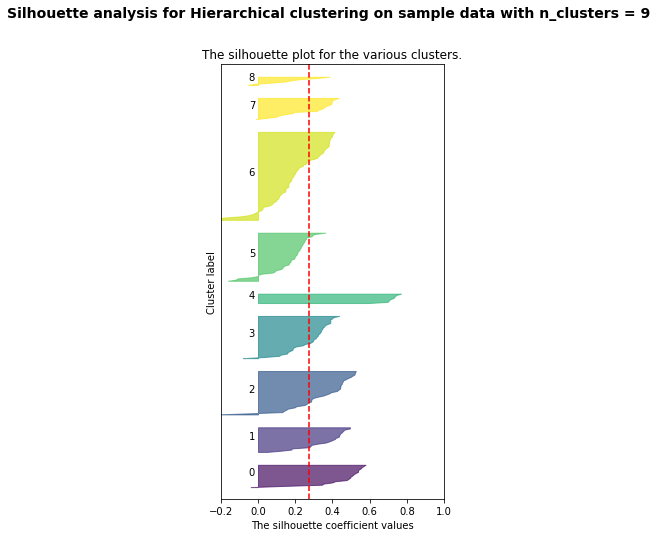

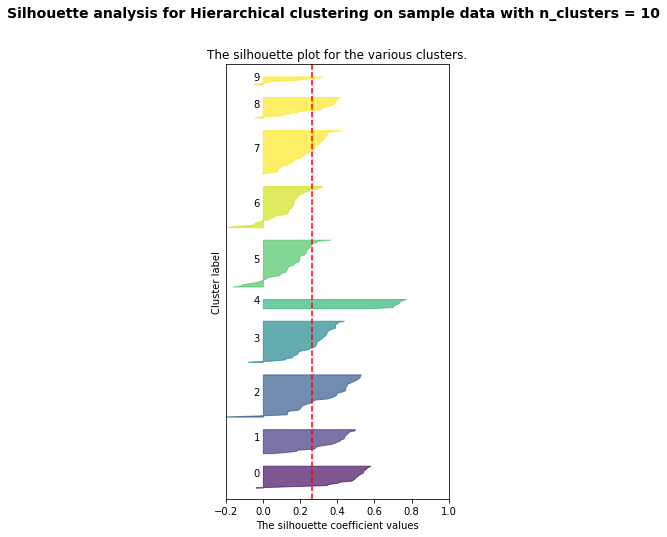

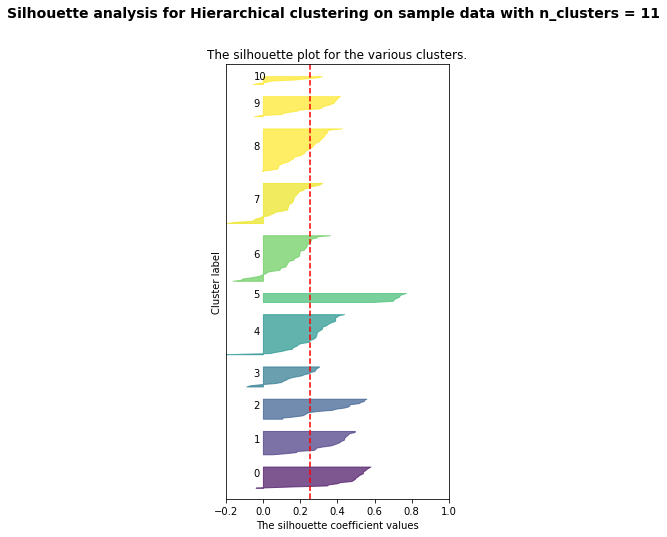

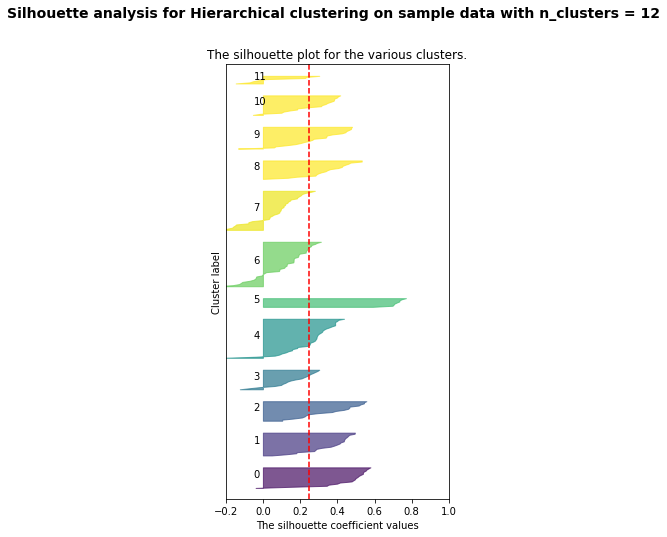

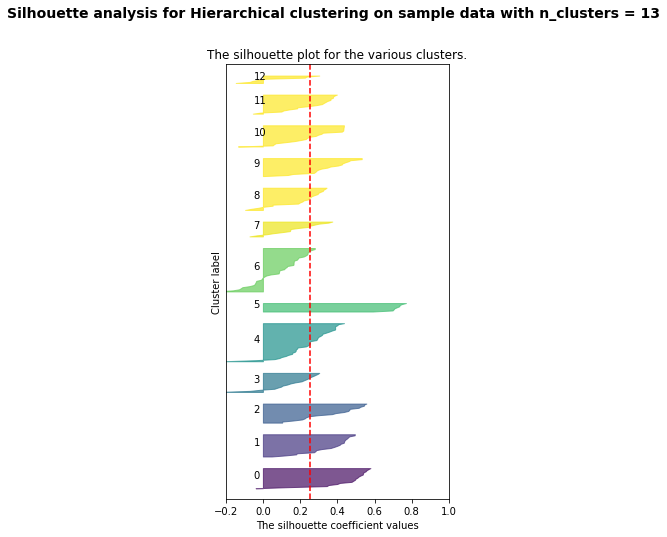

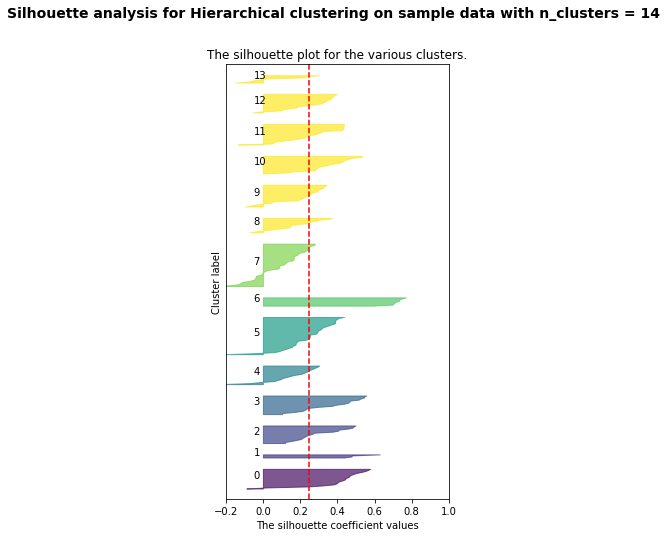

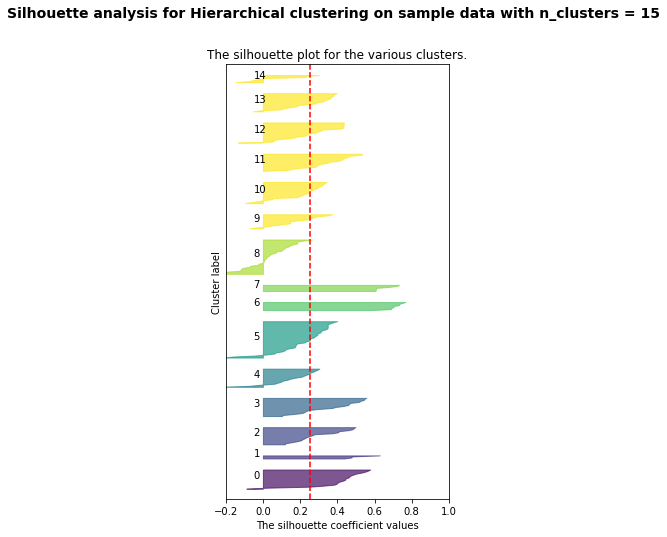

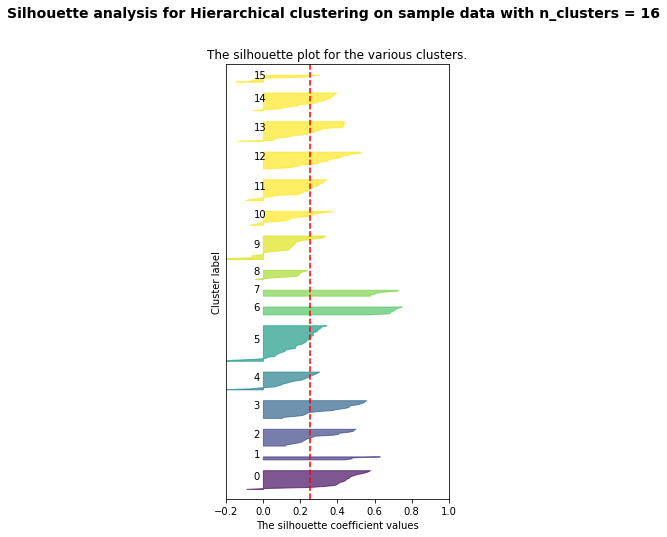

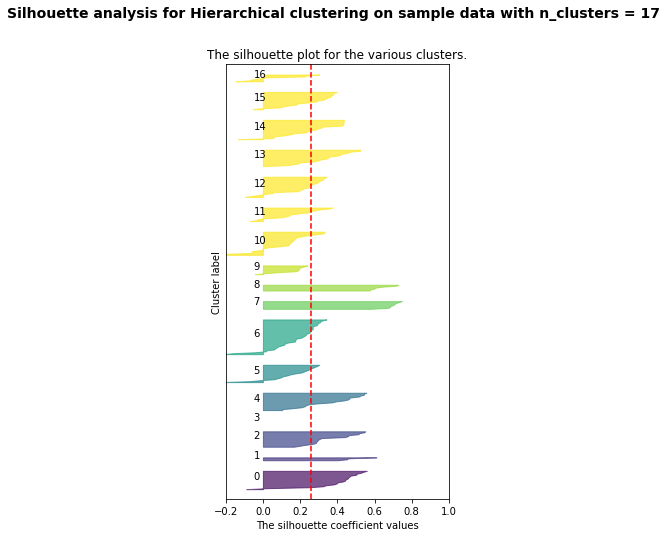

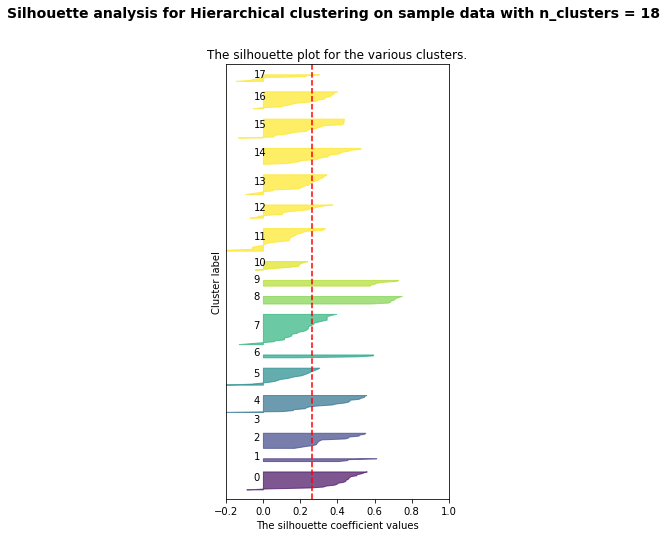

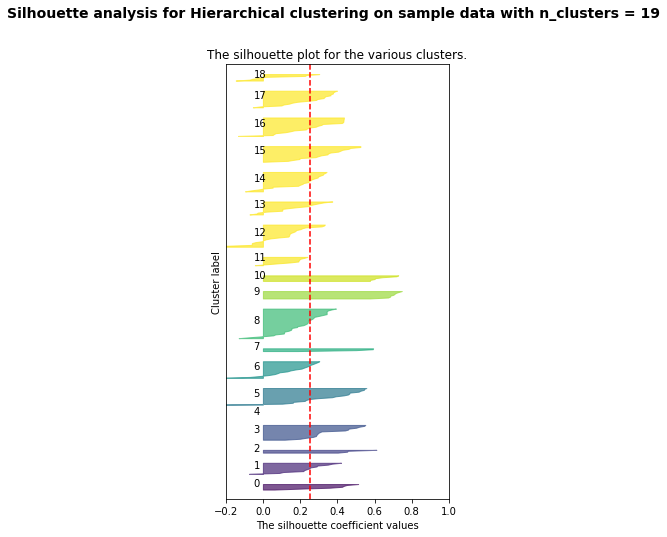

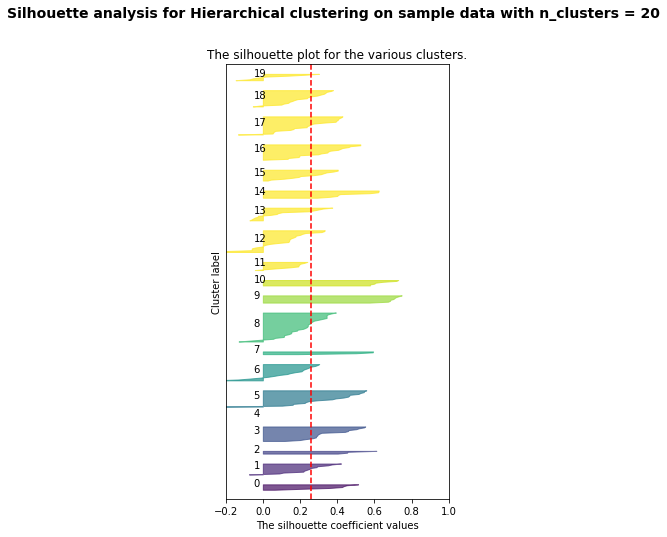

In [15]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from matplotlib.pyplot import spectral

nc = range(2,21)
scores = []
for n_clusters in nc:
    fig,ax = plt.subplots(1,1,figsize=(4,8))
    ax.set_xlim([-0.2,1])
    ax.set_ylim([0, len(D) + (n_clusters + 1) * 10])
    labels = fcluster(Z, n_clusters, criterion='maxclust')
    score = silhouette_score(D,labels,metric='precomputed')
    scores.append(score)
    sample_sil_values = silhouette_samples(D,labels,metric='precomputed')
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        #For hierarchial clustering the cluster labelling start from 1. 
        
        ith_cluster_silhouette_values = \
            sample_sil_values[labels == i+1]
        
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        cmap = plt.get_cmap('viridis')
        color = cmap(y_lower)
        
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=score, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for Hierarchical clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()     

For n_clusters = 2, silhouette score is 0.509021520614624)
For n_clusters = 3, silhouette score is 0.3458248972892761)
For n_clusters = 4, silhouette score is 0.2792889475822449)
For n_clusters = 5, silhouette score is 0.26314112544059753)
For n_clusters = 6, silhouette score is 0.2602597177028656)
For n_clusters = 7, silhouette score is 0.256934255361557)
For n_clusters = 8, silhouette score is 0.2649334669113159)
For n_clusters = 9, silhouette score is 0.27493494749069214)
For n_clusters = 10, silhouette score is 0.2619490921497345)
For n_clusters = 11, silhouette score is 0.2507346272468567)
For n_clusters = 12, silhouette score is 0.24593612551689148)
For n_clusters = 13, silhouette score is 0.25394225120544434)
For n_clusters = 14, silhouette score is 0.24891319870948792)
For n_clusters = 15, silhouette score is 0.25153958797454834)
For n_clusters = 16, silhouette score is 0.2556588053703308)
For n_clusters = 17, silhouette score is 0.257420152425766)
For n_clusters = 18, silhouet

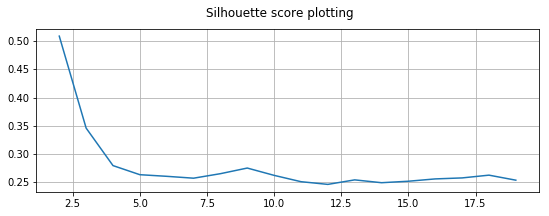

In [16]:
score_list = []
for n_clusters in range(2,20):
    labels = fcluster(Z, n_clusters, criterion='maxclust')
    score = silhouette_score(D,labels,metric='precomputed')
    score_list.append(score)
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))
    

    
names = range(2,20)
values = score_list

plt.figure(figsize=(9, 3))

plt.subplot(111)
plt.plot(names, values)
plt.suptitle('Silhouette score plotting')
plt.grid(True)
plt.show()
